# Import necessary packages


In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt

## Construct argument parser and parse the arguments

In [2]:
# ap = argparse.ArgumentParser()

# ap.add_argument("-i", "--C://Users//Ghost//Desktop//Learning_OpenCV//EAST//text_detector_using-EAST-master//beautiful.jpg", type = str)
# ap.add_argument("-east", "--C://Users//Ghost//Desktop//Learning_OpenCV//EAST//frozen_east_text_detection.pb", type = str)
# ap.add_argument("-c", "--0.5", type = float, default = 0.5)
# ap.add_argument("-w", "--320", type = int, default = 320)
# ap.add_argument("-e", "--320", type = int, default = 320)
# args = vars(ap.parse_args())

## Test image

In [3]:
image = cv2.imread("images/love.jpg")

### Current Height and Width
(h,w) = image.shape[:2]

### New Height and Width
(nh,nw) = (320,320)

### Relative Height and Width
rh,rw = h / float(nh), w / float(nw)

In [4]:
image = cv2.resize(image,(nw,nh))
(h,w) = image.shape[:2]


## LayerNames

In [5]:
### Layer names that we are interested in from EAST model
layernames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

## Load the Detection Model

In [6]:
print("-----Loading Model-----")
net = cv2.dnn.readNet("frozen_east_text_detection.pb")
print("Model Loaded :)")

-----Loading Model-----
Model Loaded :)


## Construct a blob from the image

In [7]:
blob = cv2.dnn.blobFromImage(image, 1,(w,h),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores,geometry) = net.forward(layernames)
end = time.time()

# show timing information on text prediction
print(f" text detection took {round(end-start,3)} seconds")

 text detection took 0.505 seconds


## Get Scores and Geometry

In [8]:
### The output geometry map is used to derive bounding box coordinates of text in our input images.
### The scores map contains the probability of a given region containing text.

(numRows, numCols) = scores.shape[2:4]

rects = []
confidences = []

for y in range(0, numRows):
    scoresData = scores[0, 0, y]
    xData0     = geometry[0,0,y]
    xData1     = geometry[0,1,y]
    xData2     = geometry[0,2,y] 
    xData3     = geometry[0,3,y] 
    anglesData = geometry[0,4,y]

In [9]:
### loop over the number of columns
for x in range(0, numCols):
    ### if our score does not have sufficient probability, ignore it
    if scoresData[x] < 0.5:
        continue
    ### compute the offset factor as our resulting feature maps will
    ### be 4x smaller than the input image
    (offsetX, offsetY) = (x * 4.0, y * 4.0)
    ### extract the rotation angle for the prediction and then
    ### compute the sin and cosine
    angle = anglesData[x]
    cos = np.cos(angle)
    sin = np.sin(angle)
    ### use the geometry volume to derive the width and height of
    ### the bounding box
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]
    ### compute both the starting and ending (x, y)-coordinates for
    ### the text prediction bounding box
    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
    startX = int(endX - w)
    startY = int(endY - h)
    ### add the bounding box coordinates and probability score to
    ### our respective lists
    rects.append((startX, startY, endX, endY))
    confidences.append(scoresData[x])

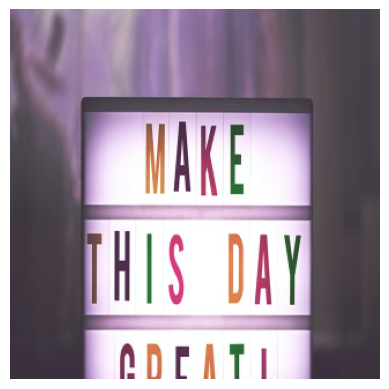

In [10]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rw)
	startY = int(startY * rh)
	endX = int(endX * rw)
	endY = int(endY * rh)
	# draw the bounding box on the image
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));
plt.axis("off");

In [11]:
def text_detector(image):
	#hasFrame, image = cap.read()
	orig = image
	(H, W) = image.shape[:2]

	(newW, newH) = (640, 320)
	rW = W / float(newW)
	rH = H / float(newH)

	image = cv2.resize(image, (newW, newH))
	(H, W) = image.shape[:2]

	layerNames = [
		"feature_fusion/Conv_7/Sigmoid",
		"feature_fusion/concat_3"]


	blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
		(123.68, 116.78, 103.94), swapRB=True, crop=False)

	net.setInput(blob)
	(scores, geometry) = net.forward(layerNames)

	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	for y in range(0, numRows):

		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability, ignore it
			if scoresData[x] < 0.5:
				continue

			# compute the offset factor as our resulting feature maps will
			# be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and then
			# compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height of
			# the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates for
			# the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score to
			# our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	boxes = non_max_suppression(np.array(rects), probs=confidences)
	for (startX, startY, endX, endY) in boxes:

		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)

		# draw the bounding box on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
	return orig,boxes
	# cv2.imshow("Text Detection", orig)
	# k = cv2.waitKey(30) & 0xff
	# if k == 27:
	# 	break

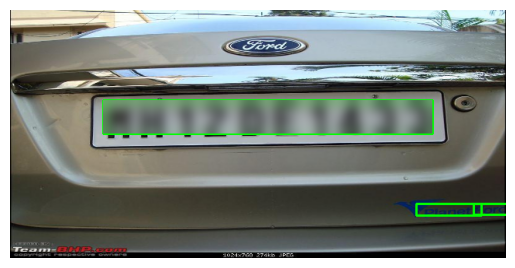

In [12]:
image = cv2.imread("images/test.JPG")
image = cv2.resize(image,(640,320))
labeled,boxes = text_detector(image)


roi = labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]]

# ### blur image 
blur_image = cv2.GaussianBlur(roi,(51,51),0)

labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]] = blur_image

plt.imshow(labeled[:,:,::-1]);
plt.axis("off");

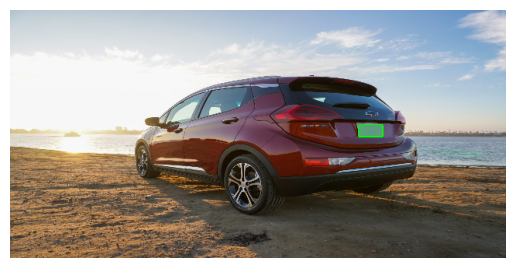

In [13]:
image = cv2.imread("images/car.JPG")
image = cv2.resize(image,(640,320))
labeled,boxes = text_detector(image)

roi = labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]]

# ### blur image 
blur_image = cv2.GaussianBlur(roi,(51,51),0)

labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]] = blur_image

plt.imshow(labeled[:,:,::-1]);
plt.axis("off");

1


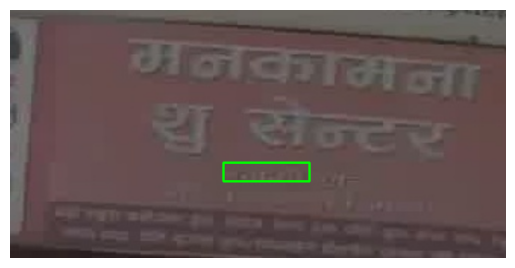

In [17]:
image = cv2.imread("images/nep.jpg")
image = cv2.resize(image,(640,320))
labeled,boxes = text_detector(image)
print(len(boxes))

roi = labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]]

# ### blur image 
# blur_image = cv2.GaussianBlur(roi,(51,51),0)

# labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]] = blur_image

plt.imshow(labeled[:,:,::-1]);
plt.axis("off");

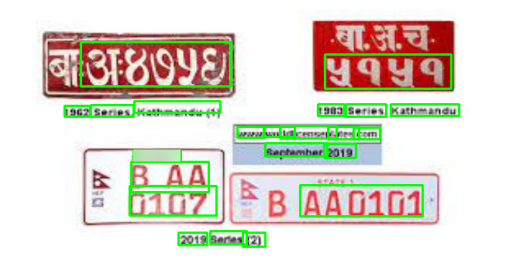

In [ ]:
image = cv2.imread("images/nepali.JPG")
image = cv2.resize(image,(640,320))
labeled,boxes = text_detector(image)

len(boxes)
roi = labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]]

# ### blur image 
blur_image = cv2.GaussianBlur(roi,(51,51),0)

labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]] = blur_image

plt.imshow(labeled[:,:,::-1]);
plt.axis("off");

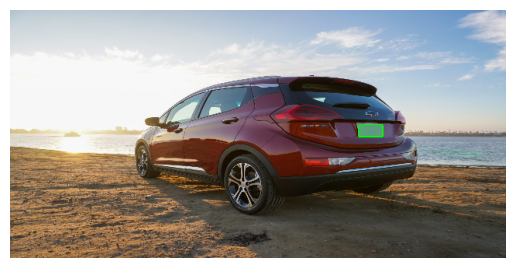

In [ ]:
image = cv2.imread("images/car.jpg")
image = cv2.resize(image,(640,320))
labeled,boxes = text_detector(image)


roi = labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]]

# ### blur image 
blur_image = cv2.GaussianBlur(roi,(51,51),0)

labeled[boxes[0][1]:boxes[0][3], boxes[0][0]:boxes[0][2]] = blur_image

plt.imshow(labeled[:,:,::-1]);
plt.axis("off");

In [ ]:
from ultralytics import YOLO

In [ ]:
model_v8 = YOLO("C://Users//Ghost//Desktop//Learning_OpenCV//Number Plate Detection//yolov8n.pt")

In [ ]:
import torch

In [ ]:
def plot_image(image):
    plt.axis('off');
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));
    plt.show();
    

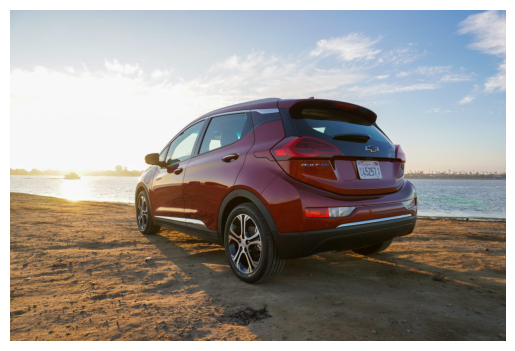

In [ ]:
cars = cv2.imread("images/car.jpg")
plot_image(cars)


0: 448x640 1 car, 1 boat, 264.0ms
Speed: 15.0ms preprocess, 264.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: '

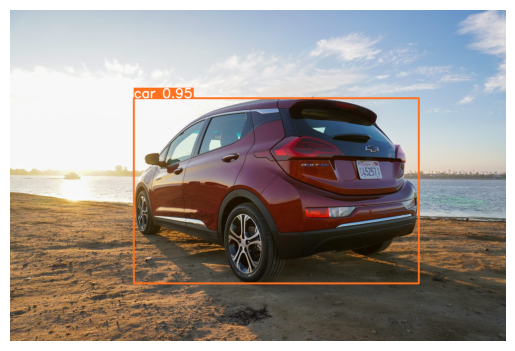

tensor([[4.7982e+02, 3.4408e+02, 1.5820e+03, 1.0598e+03, 9.5083e-01, 2.0000e+00]])


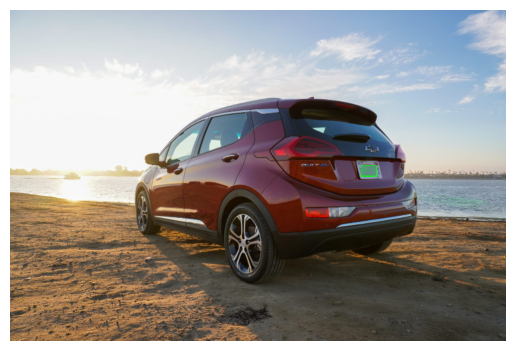

[[512 117 544 134]]


In [ ]:
cars = cv2.imread("images/car.jpg")
predict_cars = model_v8(cars)
print(predict_cars)
print(cars.shape)

### Filter only cars
predict_cars[0].boxes.data = torch.stack([box for box in predict_cars[0].boxes.data if (int(box[5]) == 2) and (box[4] > 0.5)])
boxes = predict_cars[0].boxes.data
print(f"Boxes : {boxes}")
### Plot
res_plot = predict_cars[0].plot()
plot_image(res_plot)

print(boxes)

roi =  cars[int(boxes[0][1]) : int(boxes[0][3]), int(boxes[0][0]) : int(boxes[0][2])] 
w,h,_ = roi.shape
roi = cv2.resize(roi,(640,320))

text_extracted_roi, roi_boxes = text_detector(roi)
roi_interest = text_extracted_roi[roi_boxes[0][1]:roi_boxes[0][3], roi_boxes[0][0]:roi_boxes[0][2]]
blur_cars = cv2.GaussianBlur(roi_interest,(51,51),0)
text_extracted_roi[roi_boxes[0][1] : roi_boxes[0][3], roi_boxes[0][0]:roi_boxes[0][2]] = blur_cars
text_extracted_roi = cv2.resize(text_extracted_roi,(h,w))

cars[int(boxes[0][1]) : int(boxes[0][3]), int(boxes[0][0]) : int(boxes[0][2])] = text_extracted_roi
plot_image(cars)
print(roi_boxes)

In [ ]:
w,h,r = (12,32,4)